# Восстановление золота из руды

_____

Нам необходимо подготовить прототип модели машинного обучения для компании «Цифры». Эта компания разрабатывает решения для эффективной работы промышленных предприятий.

Наша модель должна помочь оптимизировать производство и для того, чтобы не запускать предприятие с убыточными характеристиками, она будет предсказывать коэффициент восстановления золота из золотосодержащей руды. Для разработки модели мы будем использовать данные с параметрами добычи и очистки. 

Характеристики и признаки в данных следующие:

- ```rougher feed``` — исходное сырье
- ```rougher additions``` (или ```reagent additions```) — флотационные реагенты: Xanthate, Sulphate, Depressant
  - ```xanthate``` — ксантогенат (промотер, или активатор флотации);
  - ```sulphate``` — сульфат (на данном производстве сульфид натрия);
  - ```depressant``` — депрессант (силикат натрия).
- ```rougher process``` (англ. «грубый процесс») — флотация
- ```rougher tails``` — отвальные хвосты
- ```float banks``` — флотационная установка
- ```cleaner process``` — очистка
- ```rougher au``` — черновой концентрат золота
- ```final fu``` — финальный концентрат золота

Параметры этапов обозначены следующим образом:
- ```air amount``` — объём воздуха
- ```fluid levels``` — уровень жидкости
- ```feed size``` — размер гранул сырья
- ```feed rate``` — скорость подачи

Возможные значения для блока [этап]:
- ```rougher``` — флотация
- ```primary_cleaner``` — первичная очистка
- ```secondary_cleaner``` — вторичная очистка
- ```final``` — финальные характеристики

Возможные значения для блока [тип_параметра]:
- ```input``` — параметры сырья
- ```output``` — параметры продукта
- ```state``` — параметры, характеризующие текущее состояние этапа
- ```calculation``` — расчётные характеристики

Название признаков складывается следующим образом:

```[этап].[тип_параметра].[название_параметра]```



Для решения задачи мы будем придерживатья следующих шагов:

1. Загркзим и подготовим данные;
2. Проведём их исследовательский анализ;
3. Построим и обучим модель несколько моделей, выберем лучшую по значению метрик;
4. Сохранив самую успешную модель;
5. Подведём общий итог проделанной работе.

_____

## Подготовим данные

установим маленькую библиотечку для цветного шрифта:

In [1]:
!pip install colorama

Defaulting to user installation because normal site-packages is not writeable


Импортируем необходимые для работы библиотеки и модули:

In [2]:
import os
import time
import copy
import joblib
import re

import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, randint, uniform

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error

from colorama import Fore, Style

import warnings
warnings.filterwarnings('ignore')  # для итераций на LogisticRegression

RANDOM_STATE = 42

Загрузим данные, дату сделаем индексом:

In [3]:
dfs = []
for file_name in ['train.csv', 'test.csv', 'full.csv']:
    try:
        df = pd.read_csv(f'gold_industry_{file_name}', index_col=0, parse_dates=['date'])
    except FileNotFoundError:
        df = pd.read_csv(f'https://code.s3.yandex.net/datasets/gold_industry_{file_name}',
                          index_col=0, parse_dates=['date'])
    dfs.append(df)
train_df, test_df, full_df = dfs
train_df.name, test_df.name, full_df.name = 'train', 'test', 'full' 

Техническая часть работы:

Все функции, классы и методы собраны здесь сверху, так будет удобнее их вызывать и общий код будеть выглядеть аккуратнее. Для понимания работы той или иной функции все они подписаны: 

In [4]:
class RequestParameters():
    """класс с методами для отрисовки крафиков и ttest_ind-тестом"""
    
    def __init__(self, df):
        self.df = df

        
    @staticmethod
    def show_null(df):
        """для вывода статистики но нулевым значениям в датафреймах"""
        
        features_with_missing_values = df.columns[df.isnull().any()].tolist()
        missing_values_count = df[features_with_missing_values].isnull().sum()
        print(missing_values_count, '\n')
           
            
    def get_information(self):
        """выводит на печать характеристики данных - размер, 
        количество числовых и категориальных признаков"""
        
        rbr = Fore.RED + Style.BRIGHT
        br = Style.RESET_ALL + Style.BRIGHT
        r = Style.RESET_ALL
        num_cols, cat_cols = [], []
        print(f'{rbr}файл {self.df.name.upper()}{br}:\n\nразмер:{r}\n{self.df.shape}\n\n{br}пропуски:{r}')
        RequestParameters.show_null(self.df)
        print(f'{br}детальнее о признаках:{r}')
        for num, i in enumerate(self.df.columns):
            if pd.api.types.is_numeric_dtype(self.df[i]):
                print(f'{num}) {i:<50} (числовой), оригинальных значений: {len(self.df[i].unique()):>15}')
                num_cols.append(i)
            elif pd.api.types.is_object_dtype(self.df[i]):
                print(f'{num+1}) {i} (категориальный), оригинальных значений: {len(self.df[i].unique())}')
                cat_cols.append(i)
        print(f'\n{br}итого:{r}\nчисловых: {len(num_cols)}\nкатегориальных: {len(cat_cols)}')
        
        
    def get_metal_concentration(self, prefix, k, name, other_prefix=False):
        """отрисовывает изменение концентрация металлов на различных этапах очистки"""
        
        plt.figure(figsize=(12,4))
        for i in self.df.columns:
            if f'{prefix}{k}' in i:
                sns.kdeplot(self.df[i], fill=True, label=i)
            if other_prefix:
                if f'{other_prefix}{k}' in i:
                    sns.kdeplot(self.df[i], fill=True, label=i)
        plt.legend()
        plt.title(f'{name}: изменение концентрации', fontsize=16)
        plt.minorticks_on()
        plt.grid(which='major', linewidth=.5)
        plt.grid(which='minor', axis='y', linewidth=.25, linestyle='--');
        
        
    def compare_size_distribution(self, other):
        """отрисовывает распределение размеров гранул сырья на обучающей и тестовой выборках"""
        
        plt.figure(figsize=(12,4))
        sns.kdeplot(self.df['rougher.input.feed_size'], fill=True, 
                    label=f'обучающая выборка, среднее={self.df["rougher.input.feed_size"].mean():.4f}')
        sns.kdeplot(other['rougher.input.feed_size'], fill=True, 
                    label=f'тестовая выборка, среднее={other["rougher.input.feed_size"].mean():.4f}')
        plt.minorticks_on()
        plt.grid(which='major', linewidth=.5)
        plt.grid(which='minor', axis='y', linewidth=.25, linestyle='--')
        plt.title('распределения размеров гранул сырья на обучающей и тестовой выборках', fontsize=16)
        plt.legend();
        
        
    def get_ttest_ind(self, other, alpha=.05):
        """для проведения t-теста"""
        
        result, p_value = ttest_ind(self.df['rougher.input.feed_size'], 
                                    other['rougher.input.feed_size'])
        print(f'{p_value=:.4f}')
        if p_value < alpha:
            print('Распределения статистически различны')
        else:
            print('Распределения не отличаются статистически')
            
            
    def concentrations_of_substances_at_different_stages(self, add_col=True, get_plot=True):   
        """отрисовывает и добавляет суммарную концентрацию всех веществ на разных стадиях"""
        
        cols = [('rougher.input.feed', 'до флотации'), ('rougher.output.concentrate', 'после флотации'), 
                ('primary_cleaner.output.concentrate', 'после перв. обработки'),
                ('final.output.concentrate', 'финальная концентрация')]
        if add_col:
            for col in cols:
                try:
                    self.df[f'{col[0]}_au'].fillna(0, inplace=True)
                    self.df[f'{col[0]}_ag'].fillna(0, inplace=True)
                    self.df[f'{col[0]}_pb'].fillna(0, inplace=True)
                except KeyError:
                    pass
                self.df[f'{col[0]}_sum'] = full_df[f'{col[0]}_au'] + full_df[f'{col[0]}_ag'] + full_df[f'{col[0]}_pb']
        if get_plot:
            new_col = []
            fig, ax = plt.subplots(nrows=2, figsize=(12, 8))
            for col in cols:
                new_col.append(f'{col[0]}_sum')
                sns.kdeplot(self.df[f'{col[0]}_sum'], fill=True, label=col[1], ax=ax[0])
            ax[0].set_title('суммарная концентрация всех веществ на разных стадиях', fontsize=16)
            ax[0].minorticks_on()
            ax[0].grid(which='major', linewidth=.5)
            ax[0].grid(which='minor', axis='y', linewidth=.25, linestyle='--')
            ax[0].legend(loc='upper left')
            sns.boxplot(data=self.df[new_col], width=.5, fliersize=2., linewidth=.7, ax=ax[1])
            ax[1].set_xticklabels([x[1] for x in cols], rotation=0)
            ax[1].minorticks_on()
            ax[1].grid(which='major', linewidth=.5)
            ax[1].grid(which='minor', axis='y', linewidth=.25, linestyle='--');
        
        
    def distribution_of_metrics(self):
        """отрисовывает сборную таблицу с итоговыми значениями sMAPE, подсчитанными по средним метриками:"""
        
        sns.color_palette('dark:#5A9_r', as_cmap=True)
        plt.figure(figsize=(12, 4))
        baplp = self.df[['model', 'final sMAPE']].sort_values('final sMAPE')
        plt.bar(baplp['model'], baplp['final sMAPE'], color='#AED6F1', ec='#1361A2')
        plt.axhline(y=df_editor.df['final sMAPE'].min(), c='r', linestyle='--', lw=1)
        plt.title('значения final sMAPE по средним метриками', fontsize=16)
        plt.yscale('log')
        plt.xticks(rotation=10)
        plt.minorticks_on()
        plt.grid(which='major', linewidth=.5)
        plt.grid(which='minor', axis='y', linewidth=.25, linestyle='--');

In [5]:
class DataFrameEditor:
    """формирует сводный датафрейм со значениями метрик"""
    
    def __init__(self, df=None):
        if df is None:
            self.df = pd.DataFrame(columns=['model', 'sMAPE rougher.output.recovery',
                                            'sMAPE final.output.recovery', 'final sMAPE'])
            
    def add_row(self, values_dict):
        new_row = pd.DataFrame(values_dict, index=[0])
        self.df = pd.concat([self.df, new_row], ignore_index=True)
        
        
    def add(self, model, smape_rougher, smape_final, final_smape):
        self.add_row({'model': [model], 'sMAPE rougher.output.recovery': [smape_rougher], 
                      'sMAPE final.output.recovery': [smape_final], 'final sMAPE': [final_smape]}) 

In [6]:
def search_for_the_best_models(model, params, name_target, train_df, 
                               get_print=False, predict=False, final_prediction=False):
    """
    функция формирует пайплайны и в зависимости от переданных параметров
    возвращает: 
    - среднее по sMAPE
    - предсказание на отложенной выборке и значение sMAPE
    работает в связке с функциями rename_keys и get_best_pipeline
    """
    
    def rename_keys(d, prefix):
        """функция убирает префикс из названия ключа"""
        
        return {k.replace(prefix, ''): v for k, v in d.items()}

    start_time = time.time()
    if get_print:
        print(f'{Fore.CYAN + Style.BRIGHT}Прогноз для таргета {name_target}{Style.RESET_ALL}\n')
    model_obj = model
    
    # здесь формируется список признаков,которые будут переданы для обучения
    if name_target == 'rougher.output.recovery':
        features = [col for col in train_df.columns if 'input' in col]
    else:
        features = train_df.columns
    
    # если работаем не с финальным предсказанием, то формируем pipeline и подбираем гиперпараметры
    if final_prediction:
        pass
    else:
        preprocessor = ColumnTransformer(
            transformers=[('num', RobustScaler(), features)])

        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model_obj)])

        grid = RandomizedSearchCV(pipeline, param_distributions=params, cv=5, 
                                  scoring=make_scorer(smape, greater_is_better=False), 
                                  refit=False, n_iter=10, random_state=RANDOM_STATE, n_jobs=-1)

        search = grid.fit(train_df[features], targets[name_target])

        best_params = rename_keys(search.best_params_, 'model__')
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model_obj.set_params(**best_params))])
        pipeline.fit(train_df[features], targets[name_target])
    
    # если хотим после обучения сразу посчитать метрику на отложенной выборке
    if predict or final_prediction:
        # если хотим просто посчитать метрику на своих уже готовых пайплайнах
        if final_prediction:
            sMAPE = smape(test_df[name_target], model.predict(test_df[features]))
            print(f'\n{Style.BRIGHT}для {name_target} sMAPE = {sMAPE}{Style.RESET_ALL}\n')
            return sMAPE
        else:
            sMAPE = smape(test_df[name_target], pipeline.predict(test_df[features]))
            if get_print:
                print(f'модель с лучшими подобранными параметрами:\n\t{pipeline[-1]}')
                print(f'\n{Style.BRIGHT}{sMAPE=}{Style.RESET_ALL}\n')
                print(f'время подсчёта: {time.time() - start_time:.2f} сек.\n', '_'*50)
        return pipeline, sMAPE
    else:
        if get_print:
            print(f'модель с лучшими подобранными параметрами:\n\t{pipeline[-1]}\n'
                  f'среднее значение sMAPE на кросс-валидации: {-grid.best_score_}')
            print(f'время подсчёта: {time.time() - start_time:.2f} сек.\n', '_'*50)
        return pipeline, -grid.best_score_
    
    
def get_best_pipeline(model, params, targets, get_print=True, 
                      predict=False, final_predic=False, model2=False):
    """
    функция принимает словарь из гиперпараметров для pipeline, запускает обучение,
    передаёт два значения sMAPE, подсчитанных для двух таргетов, в функцию final_smape
    """
    
    # для получения финального предсказания без обучения pipeline
    if final_predic and model2:
        sm_1 = search_for_the_best_models(model=model, params=params, train_df=train_df,
                                          name_target=targets.columns[0], get_print=get_print,
                                          final_prediction=True) 
        sm_2 = search_for_the_best_models(model=model2, params=params, train_df=train_df,
                                          name_target=targets.columns[1], get_print=get_print,
                                          final_prediction=True)
        f_result = final_smape(sm_1, sm_2)
        print(f'\n{Style.BRIGHT}итоговое sMAPE = {f_result}')
        return f_result
    
    # для обучения двух pipeline для разных таргетов
    pip_sublist, smape_rougher_final = [], []
    for i in range(2):
        # чтоб параметры модели не наследовались в новом экземпляре
        model_copy = copy.deepcopy(model)
        
        pip, sm = search_for_the_best_models(model=model_copy, params=params, train_df=train_df,
                                             name_target=targets.columns[i], get_print=get_print) 
        pip_sublist.append(pip)
        smape_rougher_final.append(sm)
    
    # собираем кортеж с обученными пайплайнами по такой логике:
    # [0] элемент - название алгортма
    # [1] элемент - пайплайн для rougher.output.recovery
    # [2] элемент - пайплайн для final.output.recovery
    pipeline_list.append((type(model).__name__, pip_sublist[0], pip_sublist[1]))

    result = final_smape(smape_rougher_final[0], smape_rougher_final[1])
    print(f'\n{Style.BRIGHT}итоговое sMAPE по средним = {result}')
    
    # собираем сводный датафрейм из класса DataFrameEditor
    df_editor.add(type(model).__name__, smape_rougher_final[0], smape_rougher_final[1], result)

In [7]:
def remove_outliers_iqr(df, column, k=8.5):
    """функция для корректировки аномалий на основе IQR"""
    
    q1, q3 = df[column].quantile(.25), df[column].quantile(.75)
    iqr = q3 - q1
    lower_bound = q1 - k * iqr
    upper_bound = q3 + k * iqr
    df.loc[df[column] < lower_bound, column] = lower_bound
    df.loc[df[column] > upper_bound, column] = upper_bound
    

def remove_outliers(df):
    """функция для применения remove_outliers_iqr к _sum признакам"""
    
    sum_cols = full_df.filter(regex=re.compile('_sum')).columns.tolist()
    for name_col in sum_cols:
        try:
            if name_col in df.columns:
                remove_outliers_iqr(df, name_col)
            else:
                pass
        except:
            print('что-то пошло не так')
    print('успех!')

    
def dummy_regressor_pred(name_target, train_df, test_df):
    """для проверки итоговой модели на адекватность"""
    
    dummy = DummyRegressor(strategy='mean')
    
    if name_target == 'rougher.output.recovery':
        features = [col for col in train_df.columns if 'input' in col]
    else:
        features = train_df.columns
        
    dummy.fit(train_df[features], targets[name_target])        
    dummy_sMAPE = smape(test_df[name_target], dummy.predict(test_df[features]))
    
    print(f'dummy_sMAPE для {name_target} = {dummy_sMAPE}')
    
    return dummy_sMAPE

_____

Посмотрим на данные, которые у нас есть, их размер, тип и пропуски в них:

In [8]:
RequestParameters(train_df).get_information()

файл TRAIN:

размер:
(14579, 86)

пропуски:
rougher.input.feed_pb                                  72
rougher.input.feed_sol                                 77
rougher.input.feed_rate                                 7
rougher.input.feed_size                               101
rougher.input.floatbank10_sulfate                      31
rougher.input.floatbank10_xanthate                      7
rougher.state.floatbank10_e_air                       429
rougher.input.floatbank11_sulfate                      36
rougher.input.floatbank11_xanthate                    407
rougher.calculation.sulfate_to_au_concentrate           1
rougher.calculation.floatbank10_sulfate_to_au_feed      1
rougher.calculation.floatbank11_sulfate_to_au_feed      1
rougher.output.concentrate_sol                         18
rougher.output.tail_ag                                  1
primary_cleaner.input.sulfate                          23
primary_cleaner.input.depressant                       28
primary_cleaner.input.xantha

In [9]:
RequestParameters(test_df).get_information()

файл TEST:

размер:
(4860, 52)

пропуски:
rougher.input.feed_pb                          28
rougher.input.feed_sol                         22
rougher.input.feed_rate                         4
rougher.input.feed_size                        44
rougher.input.floatbank10_sulfate               3
rougher.input.floatbank10_xanthate              1
rougher.state.floatbank10_a_air                 1
rougher.state.floatbank10_a_level               1
rougher.state.floatbank10_b_air                 1
rougher.state.floatbank10_b_level               1
rougher.state.floatbank10_c_air                 1
rougher.state.floatbank10_c_level               1
rougher.state.floatbank10_e_air                 7
rougher.input.floatbank11_sulfate               8
rougher.input.floatbank11_xanthate             46
primary_cleaner.input.sulfate                   1
primary_cleaner.input.depressant                9
primary_cleaner.input.xanthate                 43
primary_cleaner.state.floatbank8_a_air          1
primary_

In [10]:
RequestParameters(full_df).get_information()

файл FULL:

размер:
(19439, 86)

пропуски:
rougher.input.feed_pb                100
rougher.input.feed_sol                99
rougher.input.feed_rate               11
rougher.input.feed_size              145
rougher.input.floatbank10_sulfate     34
                                    ... 
final.output.concentrate_pb            1
final.output.concentrate_sol         211
final.output.tail_ag                   1
final.output.tail_pb                 101
final.output.tail_sol                  6
Length: 63, dtype: int64 

детальнее о признаках:
0) rougher.input.feed_au                              (числовой), оригинальных значений:           19409
1) rougher.input.feed_ag                              (числовой), оригинальных значений:           19409
2) rougher.input.feed_pb                              (числовой), оригинальных значений:           19301
3) rougher.input.feed_sol                             (числовой), оригинальных значений:           19293
4) rougher.input.feed_rate          

вот что видим:
- во всех файлах встречаются пропуски
- все признаки, кроме даты, числовые, а дату мы сделали индексом
- в *test* меньше признаков, чем в *train*
- целевые переменные отсутствуют в *test*, это:
  - ```rougher.output.recovery``` - эффективность обогащения чернового концентрата
  - ```final.output.recovery``` - эффективность обогащения финального концентрата
- в признаке ```primary_cleaner.input.feed_size``` мало оригинальных значений. Этот признак про размер гранул сырья для первичной обработки после флотации. Скорее всего так и должно быть, ведь гранулы-то для первичной обработки. Не знаем, пригодится ли эта информация, но будем о ней помнить


- признаки во всех файлах практически всегда расположены чётко по производственным этапам, это:
  - ```rougher.input``` - параметры сырья для флотации:
    - *feed_au/feed_ag/feed_pb/feed_sol* - содержание золота/серебра/свинца/растворённых веществ в золотосодержащей руде до обработки
    - *feed_rate* - скорость подачи золотосодержащей руды на обработку 
    - *feed_size* - размер золотосодержащей руды перед обработкой
  - ```rougher.state``` - параметры сырья на разных этапах обработки: 
    - *floatbank-air* - содержание воздуха на одной их флотационных стадий 
    - *floatbank-level* - уровень жидкости на этой же стадии
  - ```rougher.calculation``` - расчётные характеристики после флотации, такие как:
    - *sulfate_to_au_concentrate* - отношение содержания сульфатов к содержанию золота в концентрате после флотации
    - *floatbank_sulfate_to_au_feed* - отношение содержания сульфатов к содержанию золота в питательной руде в конкретном флотационном банке
    - *au_pb_ratio* - отношение содержания золота к содержанию свинца после флотации
  - ```rougher.output``` - параметры продукта после флотации:
    - *concentrate au/ag/pb/sol* - концентрации золота/серебра/свинца/мелкодисперстных частиц твердого вещества (золи)
    - *recovery* - процентное соотношение между фактическим и теоретическим извлечением золота
    - *tail au/ag/pb/sol* - оставшиеся концентрации веществ в отвальных хвостах
  - ```primary_cleaner.input``` - характеристики руды перед первичной очисткой:
    - *sulfate* - количество сульфата, добавляемого в этап очистки. Сульфат уменьшает поверхностное натяжение между рудой и воздушными пузырьками, что способствует лучшему отделению ценных металлов
    - *depressant* - сульфид натрия, добавляемый в этап очистки для подавления нежелательных минералов. Чаще всего это делается во избежание образования серной кислоты при контакте руды с водой и воздухом
    - *feed_size* - размер частиц руды, подаваемых на этап очистки
    - *xanthate* - ксантогенат для улучшения флотации. Он образует гидрофобную поверхность на частицах руды, что способствует их отделению от воды и образованию пузырьков воздуха. Добавление ксантогената позволяет извлекать ценные металлы из руды более эффективно
  - ```primary_cleaner.output``` - характеристики руды после первичной очистки
  - ```secondary_cleaner.state``` - характеристики руды перед вторичной очисткой
  - ```secondary_cleaner.output``` - характеристики руды после вторичной очистки
  - ```final.output``` - финальные характеристики концентрата и отвальных хвостов:
    - *concentrate au/ag/pb/sol* - концентрации золота/серебра/свинца/мелкодисперстных частиц в финальном концентрате
    - *tail au/ag/pb/sol* - концентрации золота/серебра/свинца/мелкодисперстных частиц в отвальных хвостах
    - *recovery* - процентное соотношение между фактическим и теоретическим извлечением золота из руды после всех этапов обработки

_____

- ещё одно наблюдение - признаков ```rougher.calculation``` и output-параметров продукта (```rougher.output```, ```primary_cleaner.output```, ```secondary_cleaner.output``` и ```final.output```) нет в тестовой выборке. Вероятнее всего это связано с тем, что данные признаки формируются в процессе обработки руды и недоступны на начальном этапе. Проверим это предположение:

In [11]:
set(train_df.columns) ^ set(test_df.columns)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

Так и есть - все отсутствующие признаки имеют отношение к ```output```-параметрам продукта и к последующим ```calculation```-расчётным характеристикам после флотации. Использовать их в модели не стоит, так как они могут приводить к утечке целевого признака.

_____

Проверим, правильно ли рассчитана эффективность обогащения. Вычислим её на обучающей выборке для нашей целевой переменной - признака ```rougher.output.recovery``` и найдём ```MAE``` между своими расчётами и значением признака. Эффективность обогащения находим по формуле:

$$Recovery = \frac{C\cdot(F-T)}{F\cdot(C-T)} \cdot 100\%$$

где:

**C** — доля золота в концентрате после флотации/очистки (rougher.output.concentrate_au);

**F** — доля золота в сырье/концентрате до флотации/очистки (rougher.input.feed_au);

**T** — доля золота в отвальных хвостах после флотации/очистки (rougher.output.tail_au).


In [12]:
C = train_df.loc[train_df['rougher.output.recovery'].notnull(), 'rougher.output.concentrate_au']
F = train_df.loc[train_df['rougher.output.recovery'].notnull(), 'rougher.input.feed_au']
T = train_df.loc[train_df['rougher.output.recovery'].notnull(), 'rougher.output.tail_au']

mae = mean_absolute_error((C * (F - T) / (F * (C - T)) * 100), 
                          train_df.loc[train_df['rougher.output.recovery'].notnull(), 'rougher.output.recovery'])
mae

9.83758577644259e-15

```MAE``` (*Mean Absolute Error*) - метрика, измеряющая среднее абсолютное отклонение между предсказанными значениями и фактическими, она вычисляется по формуле: $$MAE = \frac{1}{n}\sum_{i=1}^{n}|y_i - \hat{y_i}|$$ 
Буквально ```MAE``` представляет собой меру ошибки между попарными наблюдениями и чем ближе значение ```MAE``` к нулю, тем меньше ошибка. В нашем примере ```MAE``` практически = 0 $\Rightarrow$ эффективность обогащения рассчитана верно, а значит значениям переменной ```rougher.output.recovery``` мы можем доверять.

_____

Теперь поищем дубликаты и не найдём их:

In [13]:
train_df.duplicated().sum(), test_df.duplicated().sum(), full_df.duplicated().sum()

(0, 0, 0)

Проверим, если ли пропуски в целевых переменных, не найдём их и сохраним целевые переменные отдельно:

In [14]:
target_variables = ['rougher.output.recovery', 'final.output.recovery']
targets = train_df[target_variables]
print(train_df[target_variables].isna().sum())

rougher.output.recovery    0
final.output.recovery      0
dtype: int64


На основе полученной информации мы можем провести предобработку данных. Что сделаем:
- уберём из тренировочных данных те признаки, которых нет в тестовых
- в тестовую выборку добавим целевые признаки из полных данных, содержащихся в ```full_df```, а то как же мы потом будем качество моделей проверять:

In [15]:
train_df = train_df[test_df.columns]
dfs[0] = train_df
dfs[0].name = 'train'
test_df[target_variables] = full_df.loc[test_df.index, target_variables]

_____

Обработаем пропуски. 

Предположение о том, что в ```full_df``` есть данные для возможного пропуска недостающих значений в ```test_df```, не подтверждается, там такая же картинка, а заполнение пропусков в тестовой выборке синтетическими данными может быть не лучшей идеей, так как такой подход может привести к искажению результатов и подобное заполнение пропусков в тестовой выборке может повлиять в дальнейшем на производительность модели и на ее способность обобщать новые данные $\Rightarrow$ оптимальным решением нам представляется удаление строк с пропущенными значениями в тестовой выборке:

In [16]:
test_df.dropna(inplace=True)

А для ```train_df``` заполним пропуски в нецелевых признаках, воспользовавшись известной нам информацией о том, что *соседние по времени параметры часто похожи и имеют близкие значения концентрации вещества*, а значит концентрация не может резко меняться, иначе это искажало бы производственную нить обогащения $\Rightarrow$ применим аргумент ```ffill``` для метода ```fillna()```, благодаря ему пропуски заполнятся предудыщими "соседскими" значениями:

In [17]:
train_df.fillna(method='ffill', inplace=True)

Проверим результат заполнения пропусков - всё ок и норм:

In [18]:
step = 1
for df in [train_df, test_df]:
    print(f'выборка:\n\t{df.name}\nразмер:\n\t{df.shape}\nпропуски:')
    RequestParameters(train_df).show_null(df)
    if step:
        print('---'* 20)
    step -= 1

выборка:
	train
размер:
	(14579, 52)
пропуски:
Series([], dtype: float64) 

------------------------------------------------------------
выборка:
	test
размер:
	(4537, 54)
пропуски:
Series([], dtype: float64) 



_____

**Предварительный вывод**: на данном этапе мы:
- загрузили предоставленные компанией "Цифры" данные и изучили их
- проверили рассчёт эффективности обогащения, вычислив её на обучающей выборке для признака ```rougher.output.recovery```, нашли ```MAE``` между своими расчётами и значением признака, разницы фактически нет, а значит значениям переменной ```rougher.output.recovery``` мы можем доверять
- изучили те признаки, которых не оказалось в тестовой выборке, все они имеют отношение к ```output```-параметрам продукта и к последующим ```calculation```-расчётным характеристикам после флотации, потому из тренировочной выборки мы их убрали
- обработали пропуски в данных:
  - удалили пропуски в тестовой выборке
  - а в тренировочной выборке пропуски заполнили при помощи метода *fillna()* с аргументом *method='ffill'*

_____

## Проведём анализ данных

Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Этапы такие:

In [19]:
[col for col in full_df.columns if ('concentrate_' in col or 'feed_' in col) \
    and any(i in col for i in ['au', 'ag', 'pb'])]

['rougher.input.feed_au',
 'rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'final.output.concentrate_au',
 'final.output.concentrate_ag',
 'final.output.concentrate_pb']

- ```rougher.input``` - исходное сырьё
- ```rougher.output``` - черновой концентрат
- ```primary_cleaner.output``` - концентрация после первой обработки
- ```final.output``` - финальная концентрация

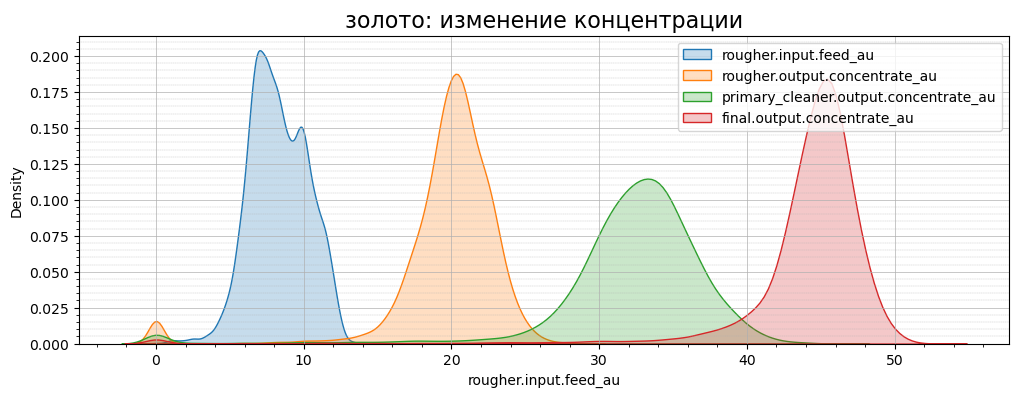

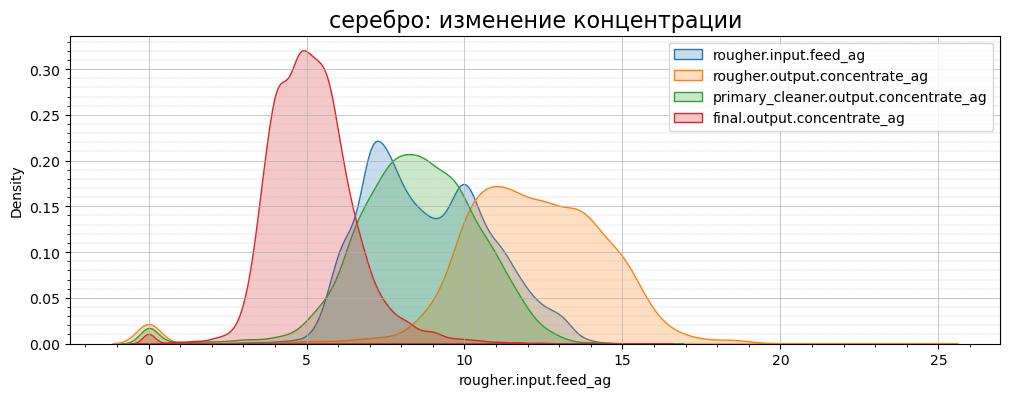

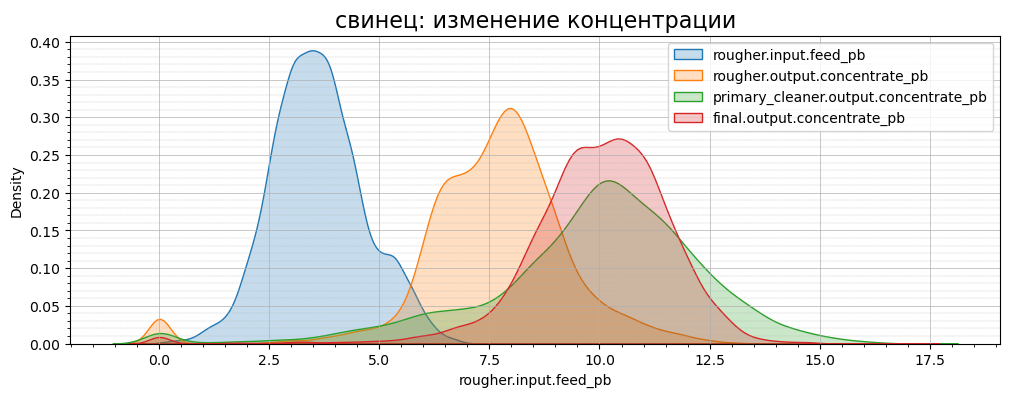

In [20]:
for i in [('au', 'золото'), ('ag', 'серебро'), ('pb', 'свинец')]:
    RequestParameters(full_df).get_metal_concentration('concentrate_', i[0], i[1], other_prefix='feed_')    

На kde-графиках распределения мы видим, что золота в финальной концентрации становится всё больше, что логично, ради него всё и делается. Количество серебра падает, а вот плюмбума меньше всего обнаруживалось в черновом концентрате, нежели в финальном концентрате и исходном сырье. причин тому может быть несколько:
- возможно неполное извлечение свинца на этапе флотации, это может быть связано с неэффективностью химических реагентов, недостаточной продолжительностью процесса флотации, низкой концентрацией свинца в руде и другими факторами
- Неполное извлечение свинца на этапе первичной очистки, такое возможно при неэффективном процессе очистки
- Неполное извлечение конкретно золота на этапе флотации
- Ошибки в данных, например, неправильно измеренные значения изначальной концентрации свинца в черновом концентрате

В пользу возможных технологических ошибок в данных говорит и тот факт, что на всех трёх этапах мы видим и некоторые значения концентраций близкие к нулю. Они могут быть связаны со сбоями в работе датчиков фиксации значений концентраций или сбоями в технологическом процессе. В любом случае, об этой особенности распределения свинца и наличие близких к нулю значений стоит сообщить компании "Цифры", которая любезно предоставила нам данные.

_____

А вот так меняется концентрация металлов (```Au```, ```Ag```, ```Pb```) на различных этапах очистки в отвальных хвостах. Этапы такие:

In [21]:
[col for col in full_df.columns if 'tail_' in col and any(i in col for i in ['au', 'ag', 'pb'])]

['rougher.output.tail_au',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'secondary_cleaner.output.tail_au',
 'secondary_cleaner.output.tail_ag',
 'secondary_cleaner.output.tail_pb',
 'final.output.tail_au',
 'final.output.tail_ag',
 'final.output.tail_pb']

- ```rougher.output.tail``` - концентрация металлов в хвостах после флотации
- ```primary_cleaner.output.tail``` - концентрация металлов в хвостах после первичной обработки
- ```secondary_cleaner.output.tail``` - концентрация металлов в хвостах после вторичной обработки
- ```final.output.tail``` - концентрация металлов в хвостах в самом финале

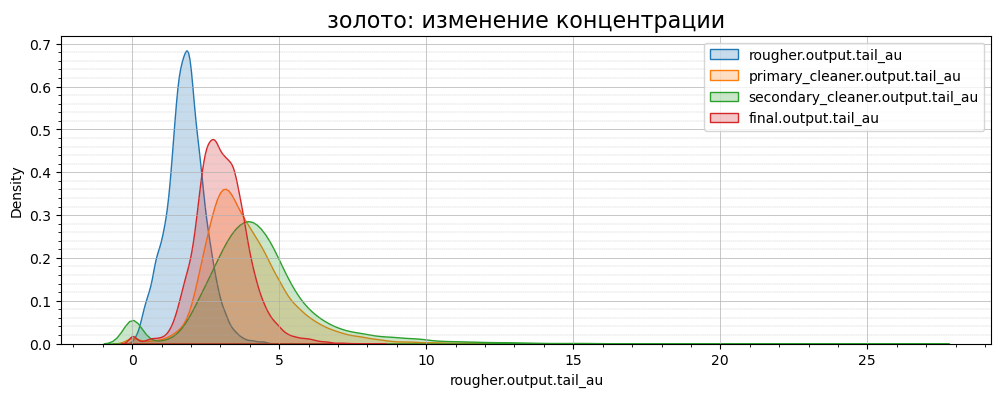

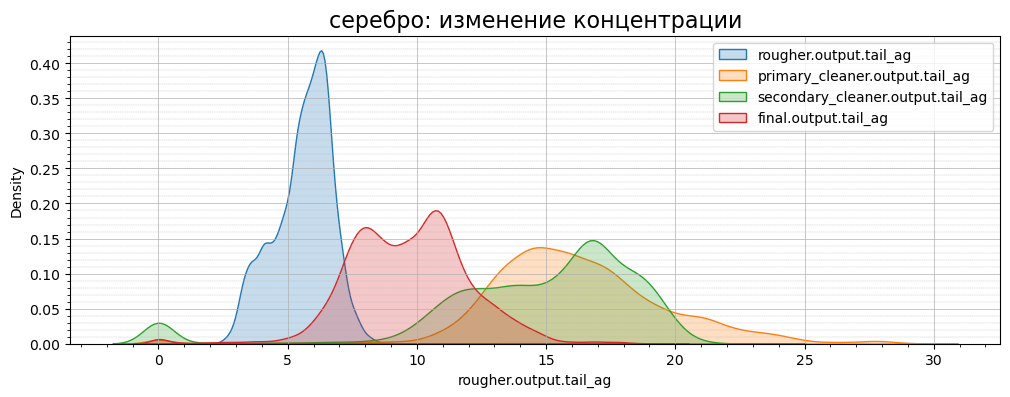

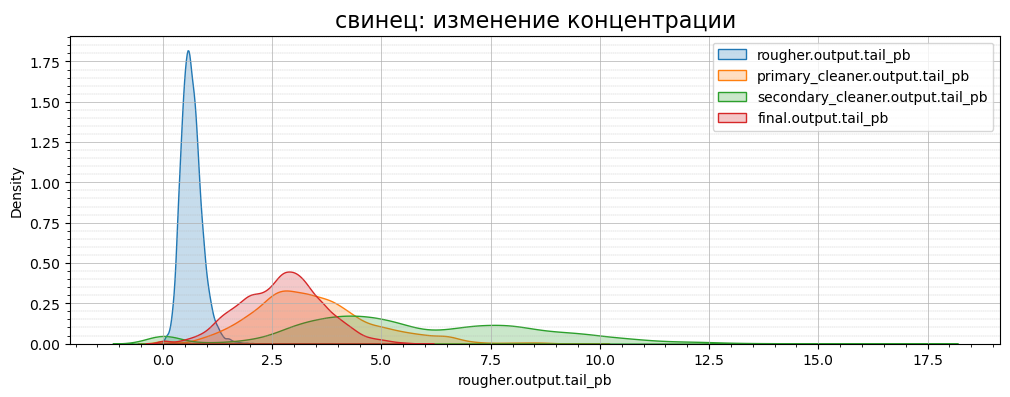

In [22]:
for i in [('au', 'золото'), ('ag', 'серебро'), ('pb', 'свинец')]:
    RequestParameters(full_df).get_metal_concentration('tail_', i[0], i[1])

На kde-графиках видим, что финальная концентрация золота в отвальных хвостах снижается, но всё же остаётся довольно высокой, а количество серебра и свинца как будто даже вырастает. Вряд ли их в действительности становится больше, скорее всего, это связано с тем, что чем ближе к технологическому финалу обработки руды, тем лучше мы их определяем.

О достаточно большом количестве золота, остающемся в отвальных хвостах и большой примеси свинца, попадающей в финальный концентрат, стоит сообщить компании "Цифры", так как, вероятно, имеет место какая-то технологиская погрешность в обрабоке руды. Возможно, качество руды может различаться в разных месторождениях, а для её обработки рименяется какой-то константный метод и стоит его пересмотреть в зависимости от характеристик конкретного месторождения.

_____

Сравним распределения размеров гранул сырья на обучающей и тестовой выборках:

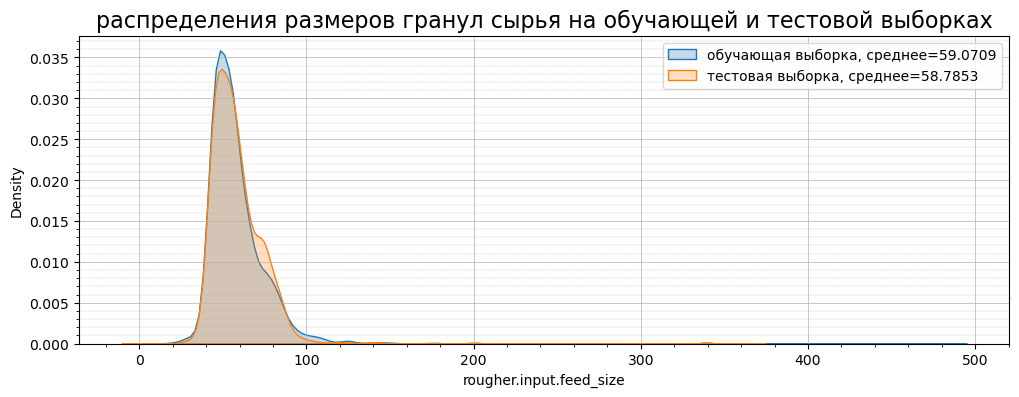

In [23]:
RequestParameters(train_df).compare_size_distribution(test_df)

Визуально разницы между распределением размеров гранул на обучающей и тестовой выборках не видно. Проверим статистически, так ли это. Мы знаем, что значения в обучающей и тестовой выборках различаются датой, а это означает то, что данные в обеих выборках были собраны в разное время и могут отличаться друг от друга, например, из-за изменения параметров оборудования, качества руды или других факторов $\Rightarrow$ будем использовать ```t-тест``` для определения равенства средних значений двух независимых выборок с уровнем значимости $\alpha=5\%$. Сформулируем гипотезы:

$H_0$ - тренировочная и тестовая выборки не отличаются статистически

$H_1$ - тренировочная и тестовая выборки статистически различны

In [24]:
RequestParameters(train_df).get_ttest_ind(test_df)

p_value=0.4466
Распределения не отличаются статистически


Теперь мы не только графически, но и статистически удостоверились в том, что с большой долей вероятности  распределения размеров гранул сырья на обучающей и тестовой выборках не имеют статистически значимых отличий.

_____

Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах: 

Отдельно рассмотрим этапы:

- ```rougher.input.feed``` - доля веществ в сырье/концентрате до флотации/очистки
- ```rougher.output.concentrate``` - доля веществ в сырье/концентрате после флотации/очистки
- ```primary_cleaner.output.concentrate``` - доля веществ в сырье/концентрате после первичной обработки
- ```final.output.concentrate``` - доля веществ в сырье/концентрате финальная

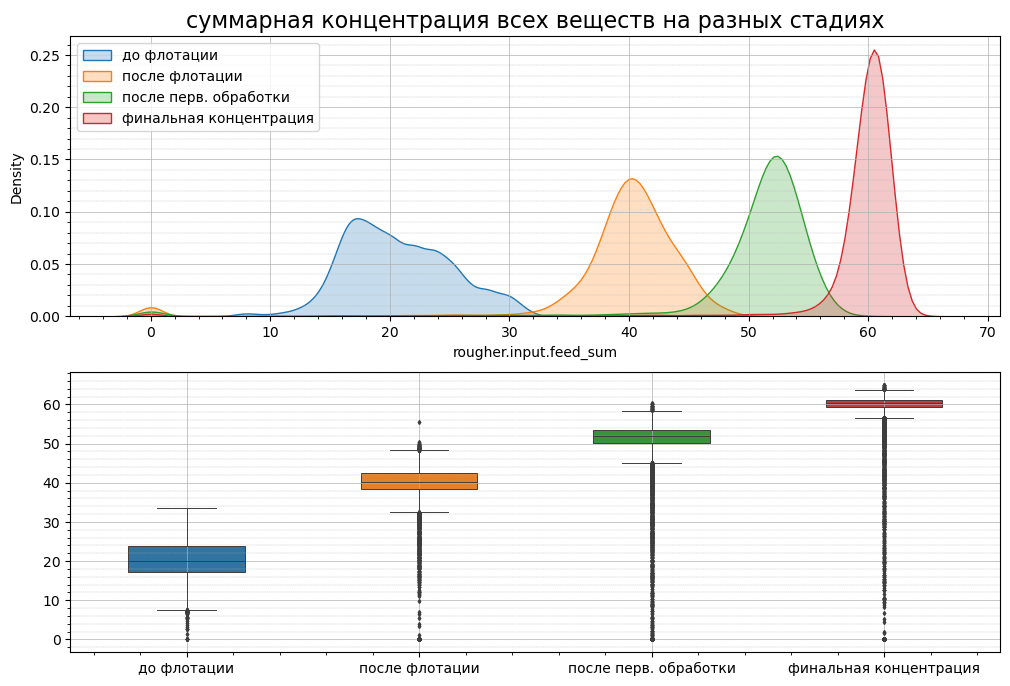

In [25]:
RequestParameters(full_df).concentrations_of_substances_at_different_stages()

На графике видно, как растёт суммарная концентрация веществ от этапа к этапу обработки сырья. При этом мы видим и значения в нуле и длинные хвосты выбросов. Длинные хвосты выбросов в распределениях могут указывать на наличие аномалий в данных. В случае производственного цикла обработки руды, когда мы имеем дело с реальными данными, подобные выбросы могут являться результатом естественных процессов, связанных с особенностями производства. 

Нули могут указывать на пустую породу, в которой нет необходимой концентрации руды, а минимальные значения могли остаться после процесса обогащения. Нельзя исключать и ранее выдвинутую версию о том, что природа подобых хвостов может заключаться в технических сбоях работы датчиков фиксации значений концентраций или сбоях в технологическом процессе. 

$\Rightarrow$ откорректируем очевидные аномальные выбросы на основе межквартильного размаха (```IQR```). Найдём для каждого признака суммарной концентрации ```Q1``` и ```Q3``` и вычислим ```IQR``` как разницу между ```Q3``` и ```Q1```, после чего определим границы, за которые выходят значения признака. Границы находятся как ```Q1-k IQR``` для нижней границы, и ```Q3+k IQR``` для верхней границы, где ```k``` - это гиперпараметр. Обозначим **k=8.5** и любое значение, которое находится за пределами диапазона от ```[Q1-6 IQR : Q3+6 IQR]```, будет считаться выбросом и заменено на соответствующее значение своей границы. 

Применим трансформацию к тестовым данным и проверим, как после удаления аномалий будет выглядеть распределение:

успех!


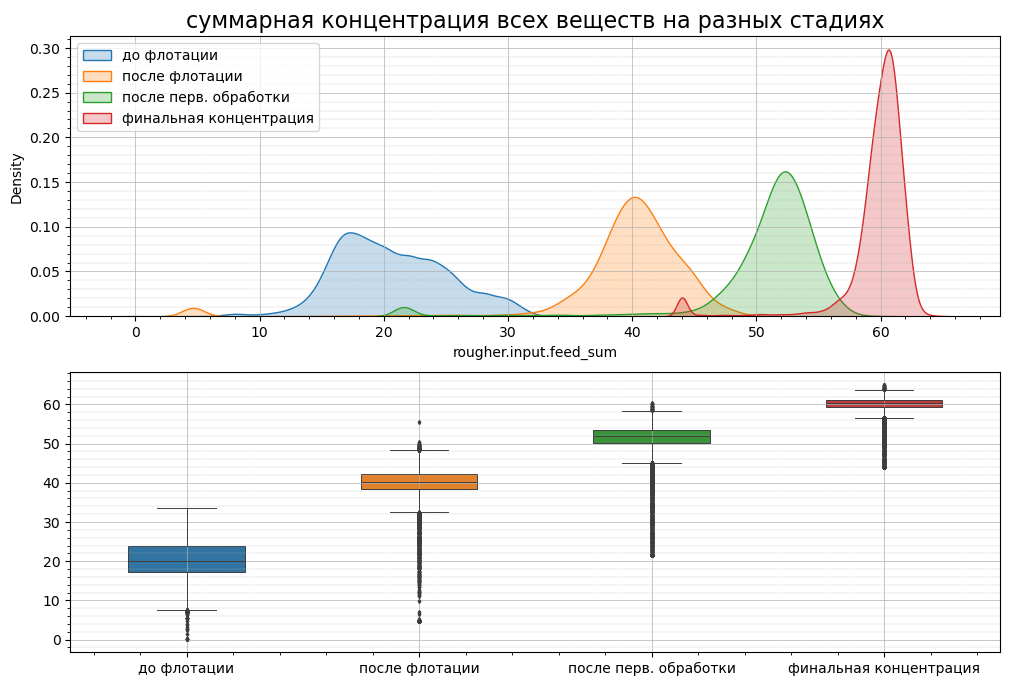

In [26]:
remove_outliers(full_df)
RequestParameters(full_df).concentrations_of_substances_at_different_stages(add_col=False)

Хвосты в нуле суммарных признаков убраны, алгоритм работает. Применим подобное преобразование к тренировочным данным, добавив к ним столбцы суммарных концентраций и убрав из них возможные аномальные значения:

In [27]:
RequestParameters(train_df).concentrations_of_substances_at_different_stages(get_plot=False)
RequestParameters(test_df).concentrations_of_substances_at_different_stages(get_plot=False)
remove_outliers(train_df)
remove_outliers(test_df)

успех!
успех!


Крайние аномалии в суммарных значениях убраны, дополнительно для Machine Learning будем использовать робастное масштабирование ```RobustScaler```, так как оно в своей формуле применяет медиану и интерквартильный размах: $s_{ij}=\frac{x_{ij} - x_{j \: median}}{Q_3(x_j)-Q_1(x_j)}$ за счёт чего делает масштабирование более устойчивым к возможным выбросам в данных, ведь для нас в исследовании важно сохранять информацию о рапределении.

_____

**Предварительный вывод**: на данном этапе мы:
- провели исследовательский анализ данных
- изучили то, как меняется концентрация металлов (```Au```, ```Ag```, ```Pb```) на различных этапах очистки, таких как:
  - концентрация в изначальном черновом концентрате
  - концентрация после первой обработки
  - финальная концентрация
- изучили изменение концентрации металлов (```Au```, ```Ag```, ```Pb```) на различных этапах очистки и в отвальных хвостах, выдвинули гипотезу о достаточно большом количестве золота, остающемся в отвальных хвостах и большой примеси свинца, попадающей в финальный концентрат
- выявили нули в распределениях изменений концентрации металлов, выдвинули несколько предпложений относительно их природы
- исследовали распределения размеров гранул сырья на обучающей и тестовой выборках, для этого использовали как графическую визуализацию распределения, так и статистический ```t-тест``` для определения равенства средних значений двух независимых выборок с уровнем значимости 𝛼=5%. Исследование показало то, что с большой долей вероятности распределения размеров гранул сырья на обучающей и тестовой выборках не имеют статистически значимых отличий, а значит этот признак пригоден для ML-моделей
- исследовали суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах, отдельно визуализировав следующие этапы:
  - доля веществ в сырье/концентрате до флотации/очистки
  - доля веществ в сырье/концентрате после флотации/очистки
  - доля веществ в сырье/концентрате после первичной обработки
  - доля веществ в сырье/концентрате финальная
- отдельно отметили то, что в суммарной концентрации сырья имеются и значения в нуле и длинные хвосты выбросов. Выдвинули несколько предположений относительно природы подобных характеристик, заменили нули и очевидные аномальные выбросы значениями, сформированными на основе межквартильного размаха (IQR), дополнительно перед Machine Learning применим робастное масштабирование.  

В целом данные исследованы, разные их особенности детально рассмотрены, пропуски обработаны, мы можем переходить к этапу моделирования.

_____

## Построим разные модели и выберем лучшую

Как метрику качества мы будем использовать ```sMAPE``` (англ. *Symmetric Mean Absolute Percentage Error*, «симметричное среднее абсолютное процентное отклонение»), она похожа на ```MAE```, но выражается не в абсолютных величинах, а в относительных, а также одинаково учитывает масштаб и целевого признака, и предсказания. А целевых признаков у нас два, так что формулы для нахождения ```sMAPE``` и ```final sMAPE``` будут выглядеть так:

$$sMAPE = \frac{1}{N}\sum\limits_{i=1}^N\frac{|y_i - \hat{y_i}|}{(|y_i|+|\hat{y_i}|)/2}\cdot100\%$$
$$ $$ $$ $$
$$final \, sMAPE = 25\% \cdot sMAPE(rougher)+75\% \cdot sMAPE(final)$$

In [28]:
def smape(y, y_pred):
    return np.mean(np.abs(y - y_pred) / ((np.abs(y) + np.abs(y_pred)) / 2)) * 100

def final_smape(smape_rougher, smape_final):        
    return .25 * smape_rougher + .75 * smape_final

_____

Определимся с признаками, которые нам пригодятся для обучения моделей для двух наших целевых переменных:

- переменная ```rougher.output.recovery``` - *эффективность обогащения чернового концентрата*. Для модели этого таргета, по правильному, нельзя использовать признаки, которые становятся известны только на следующих технологических этапах обработки руды, так как это грозит утечкой целевой переменной. Соответственно, для предсказания ```rougher.output.recovery``` мы возьмём только начальные *input*-признаки.


- переменная ```final.output.recovery``` - *эффективность обогащения финального концентрата*. Для модели этого таргета мы уже ранее оставили в ```train_df``` признаки, не грозящие утечкой целевых значений, убрав из датасета *output* и *calculations*-признаки, их и будем использовать.

_____

Находить значение ```sMAPE``` для каждой целевой переменной будем при помощи ```RandomizedSearchCV``` с кросс-валидацией на 5 фолдов. Значения признаков для ```RandomizedSearchCV``` будем формировать в пайплайне, сначала шкалируя их при помощи ```RobustScaler()```. В качестве метрики для ```RandomizedSearchCV``` передадим нашу функцию ```smape```. После подбора лучших параметров выведем на экан следующую информацию:
- название целевой переменной
- название модели с подобранными лучшими параметрами
- усреднённое значение ```sMAPE```, полученное на пяти фолдах
- время поиска ```sMAPE``` в секундах
- итоговое значение среднего ```final sMAPE```, посчитанное на средних ```sMAPE``` 

Соберём в сводную таблицу все получающиеся ```final sMAPE```, посчитанные с использованием разных ML-алгоритмов регрессии, а потом выберем лучший и проверим его на отложенной выборке, посчитав на ней ```final sMAPE``` 

_____

технический момент:
- создадим объект для сводной таблицы ```df_editor```, в него будем складывать посчитанные средние значения ```sMAPE``` на кросс-валидации
- создадим список ```pipeline_list```, в который будем собирать кортежи из трёх элементов:
  - название модели
  - пайплайн для *rougher.output.recovery*
  - пайплайн для *final.output.recovery*

In [29]:
df_editor = DataFrameEditor()
pipeline_list = list()

Теперь мы готовы перейти к моделированию:

_____

#### LinearRegression

Сначала, как водится, проверим линейную регрессию ```LinearRegression()```, переберём для неё пару параметров:

- ```fit_intercept``` - булево значение, указывающее, должен ли алгоритм оценивать перехват (True/False)
- ```positive``` - булево значение, указывающее, должны ли коэффициенты быть положительными (True/False)

In [30]:
model = LinearRegression()
params = {
    'model__fit_intercept': [True, False],
    'model__positive': [True, False],
}
get_best_pipeline(model, params, targets)

Прогноз для таргета rougher.output.recovery

модель с лучшими подобранными параметрами:
	LinearRegression(positive=True)
среднее значение sMAPE на кросс-валидации: 12.210133850257101
время подсчёта: 8.44 сек.
 __________________________________________________
Прогноз для таргета final.output.recovery

модель с лучшими подобранными параметрами:
	LinearRegression(positive=True)
среднее значение sMAPE на кросс-валидации: 11.282074302949237
время подсчёта: 1.34 сек.
 __________________________________________________

итоговое sMAPE по средним = 11.514089189776202


_____

#### Lasso

Попробуем применить методы регуляризации линейных моделей, которые используются для борьбы с переобучением и улучшения обобщающей способности модели. Основная идея методов регуляризации заключается в добавлении штрафа на веса (коэффициенты) модели. Таким образом, модель минимизирует не только среднеквадратичную ошибку, но и норму вектора весов. 

```L1-регуляризация``` (```Lasso```) добавляет к целевой функции абсолютную норму вектора весов: $\alpha \cdot ||w||_1$ -  это сумма абсолютных значений весов. L1-регуляризация может приводить к разреженности весов, так как она поощряет отбор признаков путем обнуления некоторых из них.

переберём такие гиперпараметры для ```Lasso```:
- ```alpha``` -  гиперпараметр, который определяет силу регуляризации. Чем больше значение ```alpha```, тем больше регуляризация и меньше веса модели. Значение *alpha=0* соответствует обычной линейной регрессии без регуляризации
- ```fit_intercept``` - булевый флаг, задающий необходимость использования свободного коэффициента (*intersept*) в модели. По умолчанию он *True*, т.е. intersept используется
- ```tol``` - определяет, насколько должно измениться значение функции потерь (ошибки модели) при прекращении итераций алгоритма. Если изменение функции потерь меньше, чем `tol`, то алгоритм останавливается. Большое значение `tol` может ускорить сходимость, но может также привести и к уменьшению точности модели

In [31]:
model = Lasso()
params = {
    'model__alpha': [.001, .01, .1, 1, 10, 100],
    'model__fit_intercept': [False, True],
    'model__tol': [1e-3, 1e-4, 1e-5, 1e-6]
}
get_best_pipeline(model, params, targets)

Прогноз для таргета rougher.output.recovery

модель с лучшими подобранными параметрами:
	Lasso(alpha=0.01, tol=0.001)
среднее значение sMAPE на кросс-валидации: 12.249386331528932
время подсчёта: 2.25 сек.
 __________________________________________________
Прогноз для таргета final.output.recovery

модель с лучшими подобранными параметрами:
	Lasso(alpha=0.01, tol=0.001)
среднее значение sMAPE на кросс-валидации: 11.313440921034417
время подсчёта: 14.63 сек.
 __________________________________________________

итоговое sMAPE по средним = 11.547427273658046


_____

#### Ridge

```L2-регуляризация``` (```Ridge```) добавляет к целевой функции квадрат нормы вектора весов: $0.5 \cdot \alpha \cdot ||w||^2$, здесь $\alpha$ - гиперпараметр, определяющий силу регуляризации. Штраф становится больше тогда, когда $w$ увеличивается по модулю. В результате L2-регуляризация склонна к тому, чтобы уменьшать веса всех признаков приблизительно одинаково.

Посмотрим ```Rige``` с перебором тех же гиперпараметров, что и для ```Lasso```:

In [32]:
model = Ridge()
get_best_pipeline(model, params, targets)

Прогноз для таргета rougher.output.recovery

модель с лучшими подобранными параметрами:
	Ridge(alpha=10)
среднее значение sMAPE на кросс-валидации: 12.26923589333779
время подсчёта: 1.28 сек.
 __________________________________________________
Прогноз для таргета final.output.recovery

модель с лучшими подобранными параметрами:
	Ridge(alpha=0.01, tol=0.001)
среднее значение sMAPE на кросс-валидации: 11.397837173138623
время подсчёта: 1.84 сек.
 __________________________________________________

итоговое sMAPE по средним = 11.615686853188414


_____

#### RandomForestRegressor

Посмотрим случайный ```RandomForestRegressor``` лес с такими гиперпараметрами:
- ```n_estimators``` - число деревьев в лесу. Чем больше деревьев, тем лучше качество модели, но время обучения увеличивается
- ```max_depth``` - максимальная глубина деревьев, чем больше этот параметр, тем сложнее модель
- ```min_samples_split``` - минимальное число объектов в узле, необходимое для разделения, если число объектов в узле меньше, чем *min_samples_split*, то разделение не происходит
- ```min_samples_leaf``` - минимальное число объектов в листе, если число объектов в листе меньше, чем min_samples_leaf, то лист не создается
- ```max_features``` - число признаков, которые должны быть рассмотрены при выборе разбиения, если *max_features=None*, то все признаки будут рассмотрены. Если *max_features="sqrt"*, то будет рассмотрено *sqrt(n_features)* признаков

In [33]:
model = RandomForestRegressor(random_state=RANDOM_STATE)
params = {
    'model__n_estimators': randint(50, 250),
    'model__max_depth': randint(5, 20),
    'model__min_samples_split': randint(2, 10),
    'model__min_samples_leaf': randint(1, 4),
    'model__max_features': ['sqrt', None]
}
get_best_pipeline(model, params, targets)

Прогноз для таргета rougher.output.recovery

модель с лучшими подобранными параметрами:
	RandomForestRegressor(max_depth=7, max_features='sqrt', min_samples_leaf=3,
                      min_samples_split=4, n_estimators=137, random_state=42)
среднее значение sMAPE на кросс-валидации: 12.634574624056674
время подсчёта: 326.39 сек.
 __________________________________________________
Прогноз для таргета final.output.recovery

модель с лучшими подобранными параметрами:
	RandomForestRegressor(max_depth=7, max_features='sqrt', min_samples_leaf=3,
                      min_samples_split=4, n_estimators=137, random_state=42)
среднее значение sMAPE на кросс-валидации: 10.224307136042885
время подсчёта: 1130.60 сек.
 __________________________________________________

итоговое sMAPE по средним = 10.826874008046332


_____

#### GradientBoostingRegressor

Проверим и ```GradientBoostingRegressor``` с такими гиперпараметрами:
- ```learning_rate``` - скорость обучения модели, оптимальное значение зависит от конкретной задачи, но обычно оно лежит в диапазоне от 0.01 до 0.1
- ```n_estimators``` - количество деревьев в ансамбле
- ```max_depth``` - максимальная глубина деревьев
- ```min_samples_split``` и ```min_samples_leaf``` - параметры, определяющие минимальное количество примеров, необходимое для разделения узла и для остановки рекурсии на этом узле соответственно
- ```max_features``` - максимальное количество признаков, которое может быть использовано при поиске лучшего разделения

In [34]:
model = GradientBoostingRegressor(random_state=RANDOM_STATE)
params = {
    'model__learning_rate': uniform(.01, .1),
    'model__n_estimators': randint(50, 200),
    'model__max_depth': randint(3, 8),
    'model__min_samples_split': randint(5, 50),
    'model__min_samples_leaf': randint(5, 50),
    'model__max_features': uniform(.3, .5)
}
get_best_pipeline(model, params, targets)

Прогноз для таргета rougher.output.recovery

модель с лучшими подобранными параметрами:
	GradientBoostingRegressor(learning_rate=0.035877998160001694, max_depth=6,
                          max_features=0.45585553804470547, min_samples_leaf=10,
                          min_samples_split=46, n_estimators=53,
                          random_state=42)
среднее значение sMAPE на кросс-валидации: 12.510910305013429
время подсчёта: 150.83 сек.
 __________________________________________________
Прогноз для таргета final.output.recovery

модель с лучшими подобранными параметрами:
	GradientBoostingRegressor(learning_rate=0.012058449429580245, max_depth=4,
                          max_features=0.6609993861334124, min_samples_leaf=34,
                          min_samples_split=42, n_estimators=179,
                          random_state=42)
среднее значение sMAPE на кросс-валидации: 10.274593838063286
время подсчёта: 698.19 сек.
 __________________________________________________

итоговое sM

_____

#### KNeighborsRegressor

И ещё один алгоритм! Поищем соседей для каждого значения-точки и сделаем прогноз на основе среднего или взвешенного среднего значений в $k$ ближайших соседях. Переберём следующие гиперпараметры:

- ```n_neighbors``` - количество соседей, используемых для прогнозирования целевой переменной, чем больше значение n_neighbors, тем более гладкая будет граница решения, но это может привести к ухудшению точности модели, делая её всё больше случайной "угадайкой"
- ```weights``` - веса, используемые для прогнозирования целевой переменной
- ```algorithm``` - алгоритм, который будет использован для поиска ближайших соседей
- ```leaf_size``` - размер листа, чем меньше значение leaf_size, тем более точной будет модель, но это может приводить к увеличению времени обучения

In [35]:
model = KNeighborsRegressor()
params = {
    'model__n_neighbors': range(1, 205, 5),
    'model__weights': ['uniform', 'distance'],
    'model__algorithm': ['ball_tree', 'kd_tree', 'brute', 'auto'],
    'model__leaf_size': randint(10, 50)
}
get_best_pipeline(model, params, targets)

Прогноз для таргета rougher.output.recovery

модель с лучшими подобранными параметрами:
	KNeighborsRegressor(leaf_size=45, n_neighbors=196, weights='distance')
среднее значение sMAPE на кросс-валидации: 13.155161409628525
время подсчёта: 18.48 сек.
 __________________________________________________
Прогноз для таргета final.output.recovery

модель с лучшими подобранными параметрами:
	KNeighborsRegressor(algorithm='kd_tree', leaf_size=12, n_neighbors=181)
среднее значение sMAPE на кросс-валидации: 11.554838179388115
время подсчёта: 26.51 сек.
 __________________________________________________

итоговое sMAPE по средним = 11.954918986948218


_____

Посмотрим на получившуюся сборную таблицу с итоговыми значениями ```sMAPE```, подсчитанными по средним метриками:

,model,sMAPE rougher.output.recovery,sMAPE final.output.recovery,final sMAPE
3,RandomForestRegressor,12.634575,10.224307,10.826874
4,GradientBoostingRegressor,12.510910,10.274594,10.833673
0,LinearRegression,12.210134,11.282074,11.514089
1,Lasso,12.249386,11.313441,11.547427
2,Ridge,12.269236,11.397837,11.615687
5,KNeighborsRegressor,13.155161,11.554838,11.954919


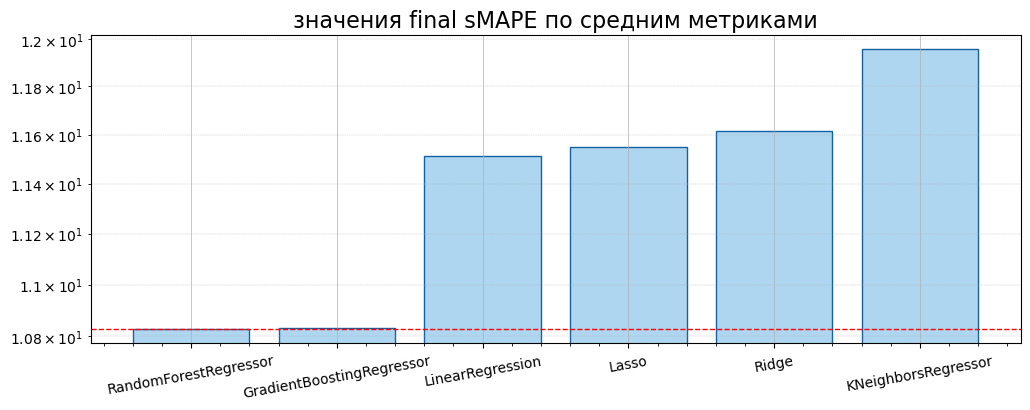

In [36]:
display(df_editor.df.sort_values('final sMAPE'))
RequestParameters(df_editor.df).distribution_of_metrics()

Из полученных значений мы видим, что худший результат показал ```KNeighborsRegressor```, при этом добрав себе ближайших соседей аж под 200 шт., а известно, что всё большее увеличение соседей для ```KNeighborsRegressor``` только приближает алгоритм в наивной модели со случайным угадыванием.

Линейные модели справились более-менее одинаково, применение L1 и L2-регуляризаций в нашем случае не помогло моделям в среднем предсказании ```final sMAPE```.

```GradientBoostingRegressor``` показал хороший результат, однако лучшее значение средней ошибки предсказания эффективности обогащения чернового и финального концентратов вернул алгоритм ```RandomForestRegressor```. ```final sMAPE``` = 10.83 означает, что наша модель на основе ```RandomForestRegressor``` в среднем находит правильный ответ в 89% случаев.

Благодаря усреднению прогноза в кросс-валидации мы смогли оценить качество модели на разных выборках тренировочных данных (фолдах), которые могли включать в себя самые разные случайные факторы, негативно сказывающиеся на "разбросе" предсказания. И сравнив полученные метрики мы смогли определиться с алгоритмом для построения ML-модели.

Определившись с алгоритмом, в дальнейшем мы будем опираться на значения метрики ```final sMAPE```, полученные на тестовых данных, так как они более точно отображают реальную способность модели к предсказанию.

_____

Посмотрим на 2 пайплайна с *RandomForestRegressor*, которые обучались на train_df для ```rougher.output.recovery``` и ```final.output.recovery```: 

In [37]:
pipeline_list[3]

('RandomForestRegressor',
 Pipeline(steps=[('preprocessor',
                  ColumnTransformer(transformers=[('num', RobustScaler(),
                                                   ['rougher.input.feed_au',
                                                    'rougher.input.feed_ag',
                                                    'rougher.input.feed_pb',
                                                    'rougher.input.feed_sol',
                                                    'rougher.input.feed_rate',
                                                    'rougher.input.feed_size',
                                                    'rougher.input.floatbank10_sulfate',
                                                    'rougher.input.floatbank10_xanthate',
                                                    'rougher.input.floatbank11_sulfate',
                                                    'rougher.input.floatbank11_xanthate',
                                         

сохраним пайплайны:

In [38]:
folder_name = 'pipelines'
prefix_list = ['_', '_rougher_output_recovery', '_final_output_recovery']
try:
    os.mkdir(folder_name)
except FileExistsError:
    pass

for i in range(1, 3):
    joblib.dump(pipeline_list[4][i], os.path.join(folder_name, f'pipeline_{dfs[i].name}{prefix_list[i]}'))

Сделаем предсказание на тренировочных данных:

In [39]:
fin_sm = get_best_pipeline(model=pipeline_list[3][1], model2=pipeline_list[3][2], targets=targets,
                           params={}, get_print=False, final_predic=True)


для rougher.output.recovery sMAPE = 5.407346144042961


для final.output.recovery sMAPE = 7.165665560583102


итоговое sMAPE = 6.7260857064480675


Мы получили итоговое значение ```sMAPE``` по обученным ранее моделям для двух таргетов, результат выглядит оптимистично, но для полной уверенности в том, что наш алгоритм действительно делает предсказание, а не просто угадывает "пальцем в небо", сравним полученное предсказание с предсказанием, возвращаемым константной моделью. Посчитаем при помощи ```DummyRegressor(strategy='mean')``` константное среднее значение:

In [40]:
dummy_preds = final_smape(dummy_regressor_pred(targets.columns[0], train_df, test_df),
                          dummy_regressor_pred(targets.columns[1], train_df, test_df))
print(f'\n{dummy_preds=}\n')
print('наша модель норм и ок') if fin_sm < dummy_preds else print('с моделью что-то не так')

dummy_sMAPE для rougher.output.recovery = 7.165813779058045
dummy_sMAPE для final.output.recovery = 9.294029989890511

dummy_preds=8.761975937182395

наша модель норм и ок


$\Rightarrow$ Наша модель прошла проверку на вменяемось, она действительно предсказывает коэффициент восстановления золота из золотосодержащей руды

_____

**Предварительный вывод**: на данном этапе мы:
- написали функции:
  - для вычисления ```sMAPE``` для каждой целевой переменной 
  - для вычисления итогового значения ```sMAPE```
- нашли среднее значение итогового ```sMAPE``` при помощи кросс-валидации с подбором лучших параметров из предложенных через ```RandomizedSearchCV```
- Отдельно рассмотрели несколько видов алгоритмов:
  - три линейных:
    - *LinearRegression*
    - *Lasso*
    - *Ridge*
  - два деревянных:
    - *RandomForestRegressor*
    - *GradientBoostingRegressor*
  - один на основе соседей:
    - *KNeighborsRegressor*
- для каждой целевой переменной на основе выбранного алгоритма построили свою модель и в итоге по наименьшему значению среднего ```final sMAPE``` оставили алгоритмы ```RandomForestRegressor``` со следующими гиперпараметрами:
  - и для rougher.output.recovery и для final.output.recovery:
    - *max_depth=7*
    - *max_features='sqrt'*
    - *min_samples_leaf=3*
    - *min_samples_split=4*
    - *n_estimators=137*
    - *random_state=42*
- лучшие пайплайны сохранили в папке ```pipelines``` каждый под своим названием:
  - *pipeline_test_rougher_output_recovery*
  - *pipeline_full_final_output_recovery*
- на основе разработанной Machine Learning-модели посчитали предсказание для целевых переменных на отложенной выборке и получили значение ```final sMAPE``` = 6.72608570644806
- при помощи модели-заглушки ```DummyRegressor(strategy='mean')```, которая всегда возвращает среднее значение целевой переменной в качестве предсказания, проверили нашу модель на адекватность и таким образом по значениям метрики ```final sMAPE``` для модели-заглушки и для нашей модели подтвердили валидность разработанного нами решения.

_____

## Общий вывод

В данном исследовани нам необходимо было подготовить прототип модели машинного обучения для компании «Цифры». Разработанная нами модель должна помочь оптимизировать производство и сократить риски запуска предриятий с убыточными характеристиками. Модель должна предсказывать коэффициент восстановления золота из золотосодержащей руды. 

Для разработки модели мы использовали данные с параметрами добычи и очистки, которые были предоставлены нам компанией "Цифры".

**Для достижения поставленной задачи  нами были проделаны следующие шаги:**
- изучены и подготовлены данные для машинного обучения
- проверен рассчёт эффективности обогащения
- проведён исследовательский анализ данных, а именно:
  - изучено то, как меняется концентрация металлов (*Au*, *Ag*, *Pb*) на различных этапах очистки как для финального концентрата, так и для отвальных хвостов
  - при помощи статистического *t-теста* и графической визуализации исследовано распределение размеров гранул сырья на обучающей и тестовой выборках
  - исследована суммарная концентрация всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах
- рассмотрено несколько алгоритмов машинного обучения и для итогового предсказания выбран тот алгоритм, который показал наилучший результат по метрике:
  - ```final sMAPE``` (*Symmetric Mean Absolute Percentage Error*) - она даёт оценку точности прогнозирования, измеряя среднее значение абсолютных процентных ошибок между фактическими и прогнозными значениями, а так же учитывая симметричность ошибок по отношению к фактическим и прогнозным значениям
- выбран алгоритм ```RandomForestRegressor``` в своей основе и с разными гиперпараметрами для предсказываемых целевых переменных:
  - ```rougher.output.recovery``` - эффективность обогащения чернового концентрата
  - ```final.output.recovery``` - эффективность обогащения финального концентрата
- выбранная лучшая модель проверена на тестовой выборке, а так же она проверена на адекватность и способность предсказывать при помощи константной модели-заглушки ```DummyRegressor```

**Отдельно хочется отметить то, что могло повлиять на исследование:**
- на основании графического исследования данных можно выдвинуть предположение о том, что достаточно большое количество золота остаётся в отвальных хвостах, а так же в финальный концентрат попадает много примесей свинца


- в распределении изменения суммарной концентрации всех металлов имелись нулевые значения. Мы их обработали, но вообще необходимо обратить внимание компании "Цифры" на эту особенность в данных. Возможно, проблемы в этом нет и появляющиеся нули при разработке руды - явление нормальное. Но нельзя исключать и проблемный технический характер в таком состоянии данных. До окончательного внедрения ML-модели требуется уточнение у компетентных специалистов относительно природы подоюных аномалий в данных. 

**Подводя итог. можно сказать:**

В результате проделанной работы мы получили модель, которая показала хорошие результаты на тестовой выборке с ```final sMAPE``` = 6.72608570644806. Это означает, что наша модель ошибается в среднем на 6.7% при предсказании коэффициента восстановления золота из золотосодержащей руды.

Мы уверены, что наша модель может быть использована компанией "Цифры" для оптимизации производства и сокращения рисков запуска убыточных предприятий. Она будет помогать компании прогнозировать коэффициент восстановления золота и принимать более эффективные решения в процессе добычи и очистки золотосодержащей руды.

_____